In [76]:
import sys
sys.path.append('../')

from functions import processing_funcs, utils

import pandas as pd

import librosa
import librosa.display

import sklearn
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture as gmm
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import numpy as np

import pickle

import IPython.display as ipd

In [16]:
train_df = pd.read_csv('../meta_data/training_files.csv', index_col=0)

In [17]:
train_df.head()

,file_path,voice_id
0,../voice_data/training/4175_L/4175_L_0.wav,0
1,../voice_data/training/4175_L/4175_L_100.wav,0
2,../voice_data/training/4175_L/4175_L_110.wav,0
3,../voice_data/training/4175_L/4175_L_120.wav,0
4,../voice_data/training/4175_L/4175_L_130.wav,0


#### Create function extract desired features from an audio clip:

In [18]:
def extract_aud_feat(audio_fp, samp_rate=8000, n_fft=128, hop_length=64, n_mfcc=13, n_mels=64):
    '''Generate a mel spectrogram of the audio sample provided and extract features from it'''
    
    y = librosa.load(audio_fp, sr=samp_rate)[0]
    
    S = librosa.feature.melspectrogram(y=y, sr=samp_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

    # Extract MFCCs from melspectrogram:
    mfccs = librosa.feature.mfcc(S=S, sr=samp_rate, n_mfcc=n_mfcc)

    # Get Delta MFCCs:
    del_mfccs = librosa.feature.delta(mfccs)
    del2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    # Root mean squared:
    rms = librosa.feature.rms(S=S, frame_length=((n_mels*2)-1), hop_length=hop_length)
    
    # Zero crossing rate:
    zcr = librosa.feature.zero_crossing_rate(y=y, frame_length=((n_mels*2)), hop_length=hop_length)
    
    # Spectral centroid:
    spec_cen = librosa.feature.spectral_centroid(S=S, sr=samp_rate, n_fft=n_fft, hop_length=hop_length)
    
    # Spectral bandwidth:
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=samp_rate, n_fft=n_fft, hop_length=hop_length)
    
    # Transpose the features and concatenate them together along axis 1 (column-wise):
    features = np.concatenate((mfccs.T, del_mfccs.T, del2_mfccs.T, rms.T, zcr.T, spec_cen.T, spec_bw.T), axis=1)
    
    # Scale features, possibly improves performance? -Performed worst on average BIC for n_components=1
    #features = preprocessing.scale(features)
    return features

#### Training a GMM Model for each Speaker based on the samples in the training dataframe:

In [29]:
# Based on code here: https://appliedmachinelearning.blog/2017/11/14/spoken-speaker-identification-based-on-gaussian-mixture-models-python-implementation/

def fit_speaker_gmms(df, dest_dir, n_components=5):
    
    # Initiliaze empty array
    feat_array = np.asarray(())
    
    # Counter to keep track of which index/voice_id we are on
    counter = 0
    
    comp_dir = dest_dir + f'/n_comp_{n_components}/'
    
    utils.make_dir(dest_dir)
    
    # Create a directory for models with the specified number of components:
    utils.make_dir(comp_dir)
    
    # Tracking for model performance:
    voice_ids = [i for i in range(0, max(test_df.voice_id.unique()) + 1)]
    bic_scores = []
    aic_scores = []
    
    # Empty dictionary to store Key: voice_id and Value: path to corresponding GMM model:
    model_dict = {}

    for audio_fp in df.file_path:
        
        tot_samp = len(df) - 1
        voice_id = df.loc[counter, 'voice_id']
        pickle_fp = f'{dest_dir}speaker_{voice_id}' + '.gmm'
        model_dict[voice_id] = pickle_fp
        
        features = extract_aud_feat(audio_fp)
            
        if feat_array.size == 0:
            feat_array = features
        else:
            feat_array = np.vstack((feat_array, features))

        # Check if we're at the last sample in the training set OR the last training sample for the current voice ID.
        # If so, fit and save the GMM for that voice ID using the accumulated features:
        if counter == tot_samp or df.voice_id[counter + 1] != voice_id:
            gmm_model = gmm(n_components=n_components, n_init=5)
            gmm_model.fit(feat_array)
            
            bic_score = gmm_model.bic(feat_array)
            aic_score = gmm_model.aic(feat_array)
            
            bic_scores.append(bic_score)
            aic_scores.append(aic_score)
            
            pickle_fp = f'{comp_dir}speaker_{voice_id}_{n_components}_n_comp' + '.gmm'
            model_dict[voice_id] = pickle_fp
            pickle.dump(obj=gmm_model, file=open(pickle_fp, 'wb'))
            #print(f'Finished with n_comp {n_components} for voice ID:', voice_id, feat_array.shape)
            # Reset the feat_array for next voice_id:
            feat_array = np.asarray(())

        counter = counter + 1
    
    model_scr_df = pd.DataFrame(list(zip(bic_scores, aic_scores)), index=voice_ids, columns =['bic_score', 'aic_score'])
    model_scr_df.to_csv(comp_dir + f'n_comp_{n_components}_scores.csv')
    
    print(f'Training complete for n_components = {n_components}.')
    
    return model_dict, model_scr_df

Testing scaling features and if it improves average BIC / AIC vs. unscaled features:

Average BIC / AIC for scaled features was MUCH worse than unscaled for n_components = 1.

Going to proceeed without scaling for now, can revisit for further evaluation.

In [30]:
%%time
# Create GMM models for each individual speaker from 1-8 n_components to evaluate using BIC/AIC scores:
# for i in range(1, 9):
#     fit_speaker_gmms(df=train_df, dest_dir='../speaker_gmm_models', n_components=i)

Creating directory at ../speaker_gmm_models...

Creating directory at ../speaker_gmm_models/n_comp_1/...



KeyboardInterrupt: 

In [31]:
# 3 components seemed to perform best for Average BIC/AIC:
model_dict, _ = fit_speaker_gmms(df=train_df, dest_dir='../speaker_gmm_models', n_components=3)

Creating directory at ../speaker_gmm_models...

Creating directory at ../speaker_gmm_models/n_comp_3/...

Training complete for n_components = 3.


In [35]:
model_dict

{0: '../speaker_gmm_models/n_comp_3/speaker_0_3_n_comp.gmm',
 1: '../speaker_gmm_models/n_comp_3/speaker_1_3_n_comp.gmm',
 2: '../speaker_gmm_models/n_comp_3/speaker_2_3_n_comp.gmm',
 3: '../speaker_gmm_models/n_comp_3/speaker_3_3_n_comp.gmm',
 4: '../speaker_gmm_models/n_comp_3/speaker_4_3_n_comp.gmm',
 5: '../speaker_gmm_models/n_comp_3/speaker_5_3_n_comp.gmm',
 6: '../speaker_gmm_models/n_comp_3/speaker_6_3_n_comp.gmm',
 7: '../speaker_gmm_models/n_comp_3/speaker_7_3_n_comp.gmm',
 8: '../speaker_gmm_models/n_comp_3/speaker_8_3_n_comp.gmm',
 9: '../speaker_gmm_models/n_comp_3/speaker_9_3_n_comp.gmm',
 10: '../speaker_gmm_models/n_comp_3/speaker_10_3_n_comp.gmm',
 11: '../speaker_gmm_models/n_comp_3/speaker_11_3_n_comp.gmm',
 12: '../speaker_gmm_models/n_comp_3/speaker_12_3_n_comp.gmm',
 13: '../speaker_gmm_models/n_comp_3/speaker_13_3_n_comp.gmm',
 14: '../speaker_gmm_models/n_comp_3/speaker_14_3_n_comp.gmm',
 15: '../speaker_gmm_models/n_comp_3/speaker_15_3_n_comp.gmm',
 16: '../spe

#### Evaluating Speaker GMMs with average BIC/AIC scores before selecting the final models:

In [36]:
gmm_dir = '../speaker_gmm_models/'
n_components = [i for i in range(1, 9)]
avg_bic_scores = []
avg_aic_scores = []

for i in n_components:
    score_df = pd.read_csv(f'{gmm_dir}n_comp_{i}/n_comp_{i}_scores.csv', index_col=0)
    avg_bic = score_df.bic_score.mean()
    avg_bic_scores.append(avg_bic)
    
    avg_aic = score_df.aic_score.mean()
    avg_aic_scores.append(avg_aic)
    
print(avg_bic_scores)

[-15482548.707891224, -17615715.412338722, -17913889.36775526, -18038365.810805395, -18109436.742697272, -18153801.751919575, -18180513.630909137, -18199456.840142883]


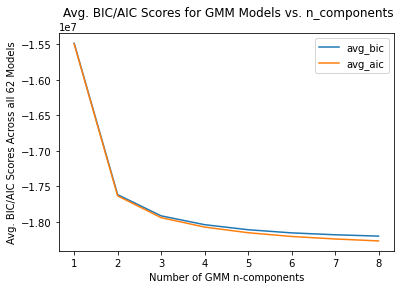

In [80]:
plt.plot(n_components, avg_bic_scores)
plt.plot(n_components, avg_aic_scores)
plt.title('Avg. BIC/AIC Scores for GMM Models vs. n_components', loc='right', y=1.05)
plt.xlabel('Number of GMM n-components')
plt.ylabel('Avg. BIC/AIC Scores Across all 62 Models')
plt.legend(['avg_bic', 'avg_aic'])
plt.savefig('../images/avg_bic_aic_scores.png')
plt.show()

Based on the inflection point around 2-3 n_components, it would appear 3 n_components might be best

#### Evaluating Speaker GMMs against test dataset:

In [38]:
test_df = pd.read_csv('../meta_data/testing_files.csv', index_col=0)

In [39]:
test_df.head()

,file_path,voice_id
0,../voice_data/testing/4175_L/4175_L_10.wav,0
1,../voice_data/testing/4175_L/4175_L_190.wav,0
2,../voice_data/testing/4175_L/4175_L_330.wav,0
3,../voice_data/testing/4175_L/4175_L_360.wav,0
4,../voice_data/testing/4175_L/4175_L_410.wav,0


In [40]:
# Speaker 55 did not have enough data to make testing data, so reusing the training data here:
train_data_55 = utils.read_dir_files('../voice_data/training/6869_R/', file_regex=None)
test_data_55 = []
for i in train_data_55:
    i = '../voice_data/training/6869_R/' + i
    test_data_55.append(i)
voice_id = [55, 55, 55, 55]

test_55_df = pd.DataFrame(list(zip(test_data_55, voice_id)), columns=['file_path', 'voice_id'])
test_55_df.head()

,file_path,voice_id
0,../voice_data/training/6869_R/6869_R_0.wav,55
1,../voice_data/training/6869_R/6869_R_10.wav,55
2,../voice_data/training/6869_R/6869_R_20.wav,55
3,../voice_data/training/6869_R/6869_R_30.wav,55


In [41]:
test_df = test_df.append(test_55_df)
test_df.head()

,file_path,voice_id
0,../voice_data/testing/4175_L/4175_L_10.wav,0
1,../voice_data/testing/4175_L/4175_L_190.wav,0
2,../voice_data/testing/4175_L/4175_L_330.wav,0
3,../voice_data/testing/4175_L/4175_L_360.wav,0
4,../voice_data/testing/4175_L/4175_L_410.wav,0


In [42]:
test_df.tail()

,file_path,voice_id
339,../voice_data/testing/6952_R/6952_R_540.wav,61
0,../voice_data/training/6869_R/6869_R_0.wav,55
1,../voice_data/training/6869_R/6869_R_10.wav,55
2,../voice_data/training/6869_R/6869_R_20.wav,55
3,../voice_data/training/6869_R/6869_R_30.wav,55


In [43]:
test_df = test_df.sort_values(by='voice_id')
test_df.head()

,file_path,voice_id
0,../voice_data/testing/4175_L/4175_L_10.wav,0
9,../voice_data/testing/4175_L/4175_L_70.wav,0
8,../voice_data/testing/4175_L/4175_L_690.wav,0
7,../voice_data/testing/4175_L/4175_L_550.wav,0
6,../voice_data/testing/4175_L/4175_L_510.wav,0


In [44]:
test_df = test_df.reset_index()

In [45]:
test_df.tail()

,index,file_path,voice_id
339,336,../voice_data/testing/6952_R/6952_R_390.wav,61
340,337,../voice_data/testing/6952_R/6952_R_460.wav,61
341,338,../voice_data/testing/6952_R/6952_R_50.wav,61
342,339,../voice_data/testing/6952_R/6952_R_540.wav,61
343,332,../voice_data/testing/6952_R/6952_R_100.wav,61


#### Create a function that will take in an audio sample, test it against each speaker's GMM model, and return the model with the highest loglikelihood score:

In [46]:
def predict_speaker(feat_array, model_paths, verbose=False):
    
    log_likelihood = np.zeros(len(model_paths))
    
    counter = 0

    for model_path in model_paths:
        
        if verbose == True:
            print(f'{counter} evaluation using model at path: {model_path}')
        
        model = pickle.load(open(model_path, 'rb'))

        score = model.score(feat_array)

        log_likelihood[counter] = score

        counter = counter + 1
    
    #print(log_likelihood)
    prediction = np.argmax(log_likelihood)
    return prediction

In [47]:
%%time
# True voice_id labels:
y_true = test_df.voice_id.unique()
y_pred = []
model_paths = list(model_dict.values())

for voice_id in range(0, len(test_df.voice_id.unique())):
    
    # Np array to stack features for voice_id cluster in:
    feat_array = np.asarray(())
    label = voice_id
    voice_id_cluster = test_df[test_df.voice_id==voice_id].reset_index(drop=True)

    for sample in range(0, len(voice_id_cluster)):
        
        audio_fp = voice_id_cluster.loc[sample, 'file_path']
        features = extract_aud_feat(audio_fp)
        
        if feat_array.size == 0:
            feat_array = features
        else:
            feat_array = np.vstack((feat_array, features))
    
    prediction = predict_speaker(feat_array, model_paths=model_paths)
    y_pred.append(prediction)
    print(f'True label: {label} Predicted label: {prediction}')
    
print('Predictions complete.')

acc_score = sklearn.metrics.accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)
print(f'Model accuracy: {acc_score}')
    

True label: 0 Predicted label: 0
True label: 1 Predicted label: 1
True label: 2 Predicted label: 38
True label: 3 Predicted label: 3
True label: 4 Predicted label: 4
True label: 5 Predicted label: 43
True label: 6 Predicted label: 6
True label: 7 Predicted label: 7
True label: 8 Predicted label: 8
True label: 9 Predicted label: 9
True label: 10 Predicted label: 10
True label: 11 Predicted label: 11
True label: 12 Predicted label: 12
True label: 13 Predicted label: 13
True label: 14 Predicted label: 14
True label: 15 Predicted label: 15
True label: 16 Predicted label: 16
True label: 17 Predicted label: 6
True label: 18 Predicted label: 24
True label: 19 Predicted label: 19
True label: 20 Predicted label: 20
True label: 21 Predicted label: 49
True label: 22 Predicted label: 22
True label: 23 Predicted label: 23
True label: 24 Predicted label: 24
True label: 25 Predicted label: 44
True label: 26 Predicted label: 26
True label: 27 Predicted label: 27
True label: 28 Predicted label: 22
True

In [71]:
acc_score = sklearn.metrics.accuracy_score(list(y_true), y_pred, normalize=True, sample_weight=None)
acc_score

0.6612903225806451

We achieved at 66.13% accuracy rate with our GMM models! Not bad at all.

If we remove Speaker 55's results since we reused training data, we achieved an overall score of 40/61 or 65.8%

Now to visualize the confusion matrix:

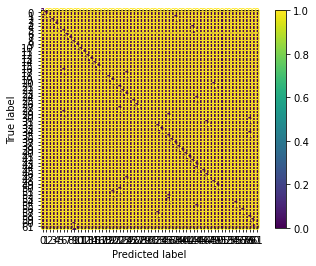

In [77]:
from sklearn.metrics import ConfusionMatrixDisplay
con_mat_disp = ConfusionMatrixDisplay.from_predictions(y_true=list(y_true), y_pred=y_pred, display_labels=np.arange(62))

This doesn't look good at all, let's try to make it larger:

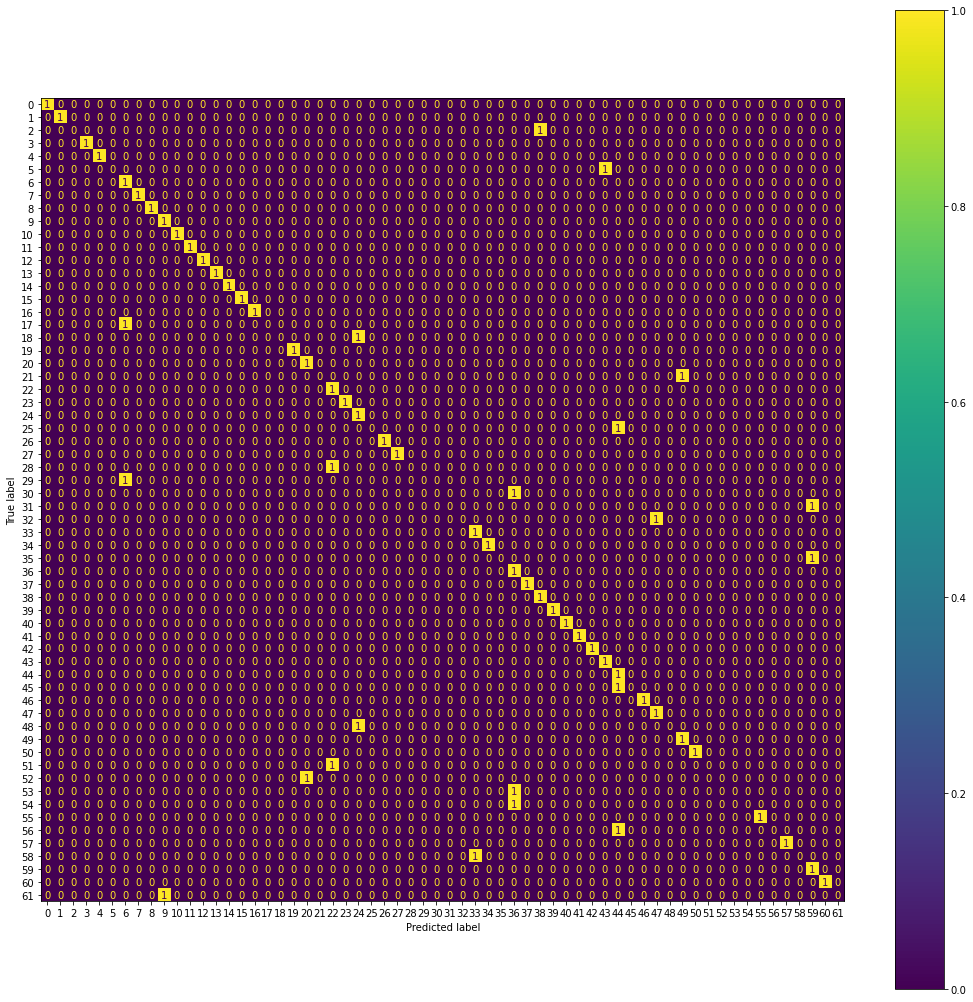

In [78]:
#con_mat_disp = ConfusionMatrixDisplay.from_predictions(y_true=list(y_true), y_pred=y_pred, display_labels=np.arange(62))
fig, ax = plt.subplots(figsize=(18,18))
con_mat_disp.plot(ax=ax)
plt.savefig('../images/conf_matrix_display.png')

Our GMM models were able to accurately identify unseen data surprisingly well given the lack of data for some speakers and other data issues (speakers changing during a call).

Applying these same techniques to a cleaner, more robust dataset would likely lead to even better results